In [14]:
import numpy as np
import pandas as pd
from sklearn import preprocessing 
from pathlib import Path
import umap
from scipy.spatial import distance

le = preprocessing.LabelEncoder()
dmdmean_file = str(Path.cwd().parent / 'results_used' / 'mean_modes.csv') 
df = pd.read_csv(dmdmean_file, index_col = 0)
df = df.reset_index()
df.label = df.label.replace([1,2,3,4], 'task')
df.label = df.label.replace([5,6,7,8], 'break')


# UMAP embedding and preparation

In [15]:
exp_nov = np.array([1 if 'e' in lab else 0 for lab in df['part']])
label = df.label
part = df['part']
parti = le.fit_transform(df['part'])
df = df.drop(['part', 'trial', 'label'], axis = 1) 
embd = umap.UMAP(
    n_components= 2, random_state=77).fit_transform(df)

embd = pd.DataFrame(embd, columns = ['U1', 'U2'])
embd['label'] = label
embd['exp_nov'] = exp_nov
embd['part'] = part

#calculate distance between subjects (between mean of trials of subjects)
dist = embd.groupby(['part','label']).mean().reset_index()
exp_task = dist[(dist.exp_nov == 1) & (dist.label == 'task')][['U1','U2']].values
nov_task = dist[(dist.exp_nov == 0) & (dist.label == 'task')][['U1','U2']].values
d_exp_task = distance.cdist(exp_task, exp_task, 'euclidean')
d_nov_task = distance.cdist(nov_task, nov_task, 'euclidean')

#calcualte distance metric between trials for each participant
mean_d = {}
df = embd[embd['label'] == 'task']
df = df.set_index('part')
df.drop(['label','exp_nov'], inplace = True, axis = 1)
for p in df.index.unique():
    this_p = df.loc[p].values
    d = distance.cdist(this_p, this_p, 'euclidean')    
    mask = np.triu(np.ones_like(d, dtype=bool))
    d = d[mask]
    d = np.delete(d, d == 0)
    mean_d[p] = np.mean(d)

mean_dist_trials = pd.Series(mean_d).to_frame()
mean_dist_trials['group'] = np.array(['FME' if 'e' in lab else 'NOV' for lab in mean_dist_trials.index])
mean_dist_trials.columns = ['mean distance', 'group']
mean_dist_trials

,mean distance,group
ea01,2.576044,FME
ea02,0.818748,FME
ea04,0.624891,FME
ea05,0.597462,FME
ea07,1.063512,FME
ea08,1.912831,FME
ea09,1.973890,FME
ea10,0.894066,FME
ea11,0.852625,FME
ea12,1.427025,FME


In [16]:
d_nov_mean = np.mean(d_nov_task, axis = 1)
d_exp_mean = np.mean(d_exp_task, axis = 1) 

mean_d_nov = pd.DataFrame(columns = ['mean distance', 'group'])
mean_d_nov['mean distance'] = d_nov_mean
mean_d_nov['group'] = 'NOV'

mean_d_exp = pd.DataFrame(columns = ['mean distance', 'group'])
mean_d_exp['mean distance'] = d_exp_mean
mean_d_exp['group'] = 'FME'

mean_dist_group = pd.concat([mean_d_exp, mean_d_nov])
mean_dist_group

,mean distance,group
0,5.197508,FME
1,6.406646,FME
2,10.010909,FME
3,9.449031,FME
4,8.592584,FME
5,5.602039,FME
6,5.035047,FME
7,9.692578,FME
8,9.615347,FME
9,5.740159,FME


# Calculate statistics

In [17]:
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

# mean distance per participant to all other participants
d_nov_mean = np.mean(d_nov_task, axis = 1)
d_exp_mean = np.mean(d_exp_task, axis = 1) 

 # distance within each participant
dist_exp_trial = list({k:mean_d[k] for k in mean_d if "e" in k}.values())
dist_nov_trial = list({k:mean_d[k] for k in mean_d if "n" in k}.values())


### Within participant

In [18]:
print('Within exp: stat = %.3f, p = %.3f' % shapiro(dist_exp_trial))
print('Within nov: stat = %.3f, p = %.3f' % shapiro(dist_nov_trial))
print('U = %.3f, p = %.3f' % mannwhitneyu(dist_exp_trial,dist_nov_trial))

Within exp: stat = 0.882, p = 0.016
Within nov: stat = 0.970, p = 0.716
U = 157.000, p = 0.037


### mean distance to all other participants

In [19]:
print('Between exp: stat = %.3f, p = %.3f' % shapiro(d_exp_mean))
print('Between nov: stat = %.3f, p = %.3f' % shapiro(d_nov_mean))
print('U = %.3f, p = %.3f' % mannwhitneyu(d_exp_mean,d_nov_mean))

Between exp: stat = 0.866, p = 0.008
Between nov: stat = 0.790, p = 0.000
U = 16.000, p = 0.000


# Visualization

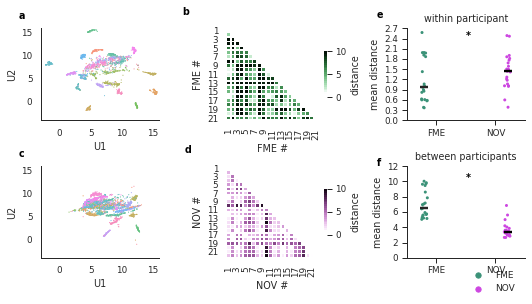

In [66]:
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

pal = sns.diverging_palette(160, 300, s=80, l=55, n=2)
cmap_nov = sns.cubehelix_palette(n_colors = 50, start=0.4, rot=0, dark=0.05, gamma = 1, hue = 1, light=2.15)
part_nov = [d for d in range(1,23)]
d_nov_task = pd.DataFrame(d_nov_task)
d_nov_task.columns = part_nov
d_nov_task.index = part_nov

cmap_exp = sns.cubehelix_palette(n_colors = 50, start=2.01, rot=0, dark=0.05, gamma = 1, hue = 1, light=2.15)
part_exp = [d for d in range(1,22)]
d_exp_task = pd.DataFrame(d_exp_task)
d_exp_task.columns = part_exp
d_exp_task.index = part_exp

sns.set_context(context='paper', font_scale=1)
sns.set_style("white")
cm = 1/2.54
fig = plt.figure(figsize = (19*cm, 11*cm))
gs = gridspec.GridSpec(4, 3)

## a
ax1 = plt.subplot(gs[:2, :1])
ax1.text(-6.5, 18, "a", horizontalalignment='left', size='medium', color='black', weight='semibold')
sns.scatterplot(x = 'U1', y = 'U2', data = embd[(embd.label == 'task') & (embd.exp_nov == 1)], 
hue = 'part', ax = ax1, palette = 'husl', legend = False, s = 1)
sns.despine(ax = ax1, top=True, right=True, left=False, bottom=False)
ax1.set_ylim(-4,16)
ax1.set_xlim(-3,16)
# ax1.set_yticklabels([])
# ax1.set_xticklabels([])
ax1.set_xlabel('U1')
ax1.set_ylabel('U2')

## b
ax2 = plt.subplot(gs[:2, 1:2])
ax2.text(-10, -3, "b", horizontalalignment='left', size='medium', color='black', weight='semibold')
mask = np.triu(np.ones_like(d_exp_task, dtype=bool))
sns.heatmap(d_exp_task, mask=mask, cmap= cmap_exp, center=0, vmin = 0, vmax = 10,square=True, 
            linewidths=.5, cbar_kws={"shrink": .5, "label": "distance"}, ax = ax2,
            yticklabels= 2, xticklabels=2)
ax2.set_yticklabels(ax2.get_yticklabels(), rotation = 0)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 90)
ax2.set_xlabel('FME #')
ax2.set_ylabel('FME #')

## c
ax3 = plt.subplot(gs[2:, :1])
ax3.text(-6.5, 18, "c", horizontalalignment='left', size='medium', color='black', weight='semibold')
sns.scatterplot(x = 'U1', y = 'U2', data = embd[(embd.label == 'task') & (embd.exp_nov == 0)], 
hue = 'part', ax = ax3, palette = 'husl', legend = False, s = 1)
sns.despine(ax = ax3, top=True, right=True, left=False, bottom=False)
ax3.set_ylim(-4,16)
ax3.set_xlim(-3,16)
# ax3.set_yticklabels([])
# ax3.set_xticklabels([])
ax3.set_xlabel('U1')
ax3.set_ylabel('U2')

## d
ax4 = plt.subplot(gs[2:, 1:2])
ax4.text(-10, -3, "d", horizontalalignment='left', size='medium', color='black', weight='semibold')
mask = np.triu(np.ones_like(d_nov_task, dtype=bool))
sns.heatmap(d_nov_task, mask=mask, cmap= cmap_nov, center=0, vmin = 0, vmax = 10,square=True, 
            linewidths=.5, cbar_kws={"shrink": .5, "label": "distance"}, ax = ax4,
            yticklabels= 2, xticklabels=2)
ax4.set_yticklabels(ax4.get_yticklabels(), rotation = 0)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation = 90)
ax4.set_xlabel('NOV #')
ax4.set_ylabel('NOV #')

## e
with sns.axes_style("ticks"):
    ax5 = fig.add_subplot(gs[:2, 2])
# ax5 = plt.subplot(gs[1:3, 2])
    ax5.text(-1, 3.0, "e", horizontalalignment='left', size='medium', color='black', weight='semibold')
    sns.stripplot(y = 'mean distance', x = 'group', hue = 'group',
                data= mean_dist_trials,
                dodge = True, alpha=1, zorder=1, s = 3, ax = ax5, palette = pal)
    sns.pointplot(y = 'mean distance', x = 'group', hue = 'group',
                data= mean_dist_trials, dodge=.42, join=False, color = 'k',markers=["_","_"],
                ci=None, estimator = np.median, ax = ax5, scale = 1.5)
    ax5.set_ylim(0,2.7)
    ax5.set_yticks(np.arange(0,2.8,0.3))
    ax5.set_xlabel(None)
    ax5.get_legend().remove()
    ax5.text(.5, 2.4, "*", size='medium', color='black', weight='semibold')
    ax5.set_title('within participant')
    sns.despine(ax = ax5)

## f
with sns.axes_style("ticks"):
    ax6 = fig.add_subplot(gs[2:, 2])
    ax6.text(-1, 12.0, "f", horizontalalignment='left', size='medium', color='black', weight='semibold')
    sns.stripplot(y = 'mean distance', x = 'group', hue = 'group',
                data= mean_dist_group,
                dodge = True, alpha=1, zorder=1, s = 3, ax = ax6, palette = pal)
    sns.pointplot(y = 'mean distance', x = 'group', hue = 'group',
                data= mean_dist_group, dodge=.42, join=False, color = 'k',markers=["_","_"],
                ci=None, estimator = np.median, ax = ax6, scale = 1.5)
    ax6.set_ylim(0,12)
    ax6.set_yticks(np.arange(0,14,2))
    ax6.set_xlabel(None)
    handles, labels = ax5.get_legend_handles_labels()
    ax6.legend(handles[:2], ['FME','NOV'], title="",bbox_to_anchor=(.5, -.1), loc=2, borderaxespad=0.,frameon=False, markerscale = 0.7, fontsize = 9)
    ax6.text(.5, 10, "*", size='medium', color='black', weight='semibold')
    ax6.set_title('between participants')
    sns.despine(ax = ax6)

fig.tight_layout(h_pad = -.5)
fig.savefig(str(Path.cwd().parent / 'Figures' / 'eeg_vis_umap_dist.svg'))